# 1. Install PIP's

In [231]:
# geo files for Brazil
%pip install unidecode
%pip install spacy
%pip install seaborn
%pip install nltk
%pip install stats
%pip install xgboost
%pip install sweetviz
%pip install string

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement string (from versions: none)
ERROR: No matching distribution found for string


# 2. Import Packages

In [232]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import spacy
import string
import regex as re
from unidecode import unidecode
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

# 3. Load Data

In [233]:
customers_df = pd.read_csv("olist_customers_dataset.csv")
geolocation_df = pd.read_csv("olist_geolocation_dataset.csv")
order_items_df = pd.read_csv("olist_order_items_dataset.csv")
order_payments_df = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews_df = pd.read_csv("olist_order_reviews_dataset.csv")
orders_df = pd.read_csv("olist_orders_dataset.csv")
products_df = pd.read_csv("olist_products_dataset.csv")
sellers_df = pd.read_csv("olist_sellers_dataset.csv")
product_category_name_translation_df = pd.read_csv("product_category_name_translation.csv")

# 4. Data Wreangling

### 4.1. Merge Data

In [234]:
df = orders_df.merge(order_reviews_df, on='order_id')\
                   .merge(order_items_df, on='order_id')\
                   .merge(products_df, on='product_id')\
                   .merge(sellers_df, on='seller_id')\
                   .merge(geolocation_df, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')

### 4.2. Selected Columns Important

In [235]:
selected_columns = ['review_id', 'review_score', 'review_comment_title', 
                    'review_comment_message', 'review_creation_date', 
                    'review_answer_timestamp', 'product_id', 
                    'geolocation_lat', 'geolocation_lng']

full_df = df.loc[:, selected_columns]

### 4.3. Conversion Columns Data in datetime

In [236]:
datetime_columns = ['review_creation_date', 'review_answer_timestamp']
full_df[datetime_columns] = full_df[datetime_columns].apply(pd.to_datetime)

### 4.4. Drop Duplicates and NA

In [271]:
full_df = full_df.drop_duplicates(subset=['review_id'])
full_df['review_comment_message'] = full_df['review_comment_message'].str.strip()
full_df.dropna(subset=['review_comment_message'], inplace=True)
full_df = full_df.dropna(subset=['review_comment_message'])
full_df = full_df.dropna(subset=['review_score'])

### 4.5. Conversion Column Message in Lower Case

In [238]:
full_df['review_comment_message'] = full_df['review_comment_message'].str.lower()

### 4.6. Space removed at the beginning and end of the message

In [239]:
full_df['review_comment_message'] = full_df['review_comment_message'].str.strip()

### 4.7. Removing Punctuation, Exemple (".", "!")

In [240]:
punct = string.punctuation
punct = punct.replace("'","")
full_df['review_comment_message'] = full_df['review_comment_message'].str.translate(str.maketrans("","",punct))

### 4.8. Removing Emoji

In [241]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # símbolos e pictogramas
                           u"\U0001F680-\U0001F6FF"  # transporte e símbolos de mapa
                           u"\U0001F1E0-\U0001F1FF"  # bandeiras (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: emoji_pattern.sub(r'', x))

### 4.9. Removing Sites and Blogs

In [242]:
http = r"http\S+|www\.\S+"
pattern = re.compile(r"({})".format(http))
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: pattern.sub(r'', x))

### 4.10. Removing Accentuation

In [243]:
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: unidecode(x))

### 4.11. Lematization

In [244]:
nlp = spacy.load('pt_core_news_sm')
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

In [245]:
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: re.sub(r'\d+', '', x))

In [290]:
# Substituir quebras de linha por espaços em branco
full_df['review_comment_message'] = full_df['review_comment_message'].str.replace('\n', ' ')

# Remover espaços em branco extras no início e no final de cada texto
full_df['review_comment_message'] = full_df['review_comment_message'].str.strip()

# Remover espaços extras dentro do texto
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: re.sub(r'\s+', ' ', x))

In [291]:
full_df.head(5)

,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,geolocation_lat,geolocation_lng
0,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,nao testar o produto ainda mas ele vir correto e em bom condicoe apenas o caixa que vir bem amassar e danificar o que ficarar chato pois se tratar de um presente,2017-10-11,2017-10-12 03:43:48,87285b34884572647811a353c7ac498a,-23.680114,-46.452454
207,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,muito bom o produto,2018-08-08,2018-08-08 18:37:50,595fac2a385ac33a80bd5114aec74eb8,-19.810119,-43.984727
448,359d03e676b3c069f62cadba8dd3f6e8,5,NaN,o produto ser exatamente o que eu esperar e estar descrito em o site e chegar bem antes de o data prever,2017-12-03,2017-12-05 19:21:58,d0b61bfb1de832b15ba9d266ca96e5b0,-19.840168,-43.923299
620,e07549ef5311abcc92ba1784b093fb56,2,NaN,fiquei tristir por n ter eu atendir,2017-05-13,2017-05-13 20:25:42,a1804276d9941ac0733cfd409f5206eb,-23.536892,-46.713111
1468,15898b543726a832d4137fbef5d1d00e,1,NaN,aguardar retorno de o loja,2017-05-30,2017-05-30 23:13:47,08574b074924071f4e201e151b152b4e,-20.297537,-40.400869


# 5. Previus Analyze

In [292]:
def df_metadata(df):
    metadata = pd.DataFrame(df.dtypes,columns=['dtypes'])
    metadata = metadata.reset_index()
    metadata['Column'] = metadata['index']
    metadata = metadata[['Column','dtypes']]
    metadata['# Missing'] = df.isnull().sum().values    
    metadata['# Unique'] = df.nunique().values
    metadata['Example'] = df.loc[0].values

    for name in metadata['Column'].value_counts().index:
        metadata.loc[metadata['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return metadata
    
df_metadata(full_df)

,Column,dtypes,# Missing,# Unique,Example,Entropy
0,review_id,object,0,40095,a54f0611adc9ed256b57ede6b6eb5114,15.29
1,review_score,int64,0,5,4,1.90
2,review_comment_title,object,30373,4088,NaN,10.00
3,review_comment_message,object,0,32741,nao testar o produto ainda mas ele vir correto e em bom condicoe apenas o caixa que vir bem amassar e danificar o que ficarar chato pois se tratar de um presente,14.23
4,review_creation_date,datetime64[ns],0,618,2017-10-11 00:00:00,8.78
5,review_answer_timestamp,datetime64[ns],0,40069,2017-10-12 03:43:48,15.29
6,product_id,object,0,17970,87285b34884572647811a353c7ac498a,13.17
7,geolocation_lat,float64,0,1891,-23.680114,8.82
8,geolocation_lng,float64,0,1891,-46.452454,8.82


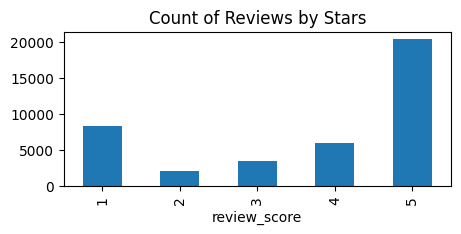

In [293]:
ax = full_df['review_score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(5,2))

In [294]:
example = full_df['review_comment_message'].iloc[4]
print(example)

aguardar retorno de o loja


# 6. Training Model

### 6.1. Separeting Dataframe Training and Dataframe Test After Training

In [345]:
# Amostra os dados para df_train
df_train = full_df.sample(frac=0.95, random_state=45, ignore_index=True)

# Seleciona as linhas que não estão presentes em df_train para df_remaining
df_remaining = full_df.loc[~full_df.index.isin(df_train.index)].reset_index(drop=True)

In [346]:
# Verificar o número de linhas em df_train e df_remaining
total_rows = len(full_df)
print("Número total de linhas:", total_rows)
num_linhas_df_train = df_train.shape[0]
num_linhas_df_remaining = df_remaining.shape[0]

print("Número de linhas em df_train:", num_linhas_df_train)
print("Número de linhas em df_remaining:", num_linhas_df_remaining)


Número total de linhas: 40095
Número de linhas em df_train: 38090
Número de linhas em df_remaining: 40000


In [336]:
df_positive = df_train[df_train['review_score'] > 3]  # considerando 4 e 5 como positivos
df_negative = df_train[df_train['review_score'] < 3]  # considerando 1 e 2 como negativos

# Igualar o número de amostras positivas e negativas
df_positive_equal = df_positive.sample(n=len(df_negative), random_state=42)

# Verificar o número de amostras após o balanceamento
print("Número de amostras positivas (após balanceamento):", len(df_positive_equal))

# Concatenar os DataFrames positivo e negativo igualizados
df_balanced = pd.concat([df_positive_equal, df_negative], ignore_index=True)

# Verificar novamente o número de amostras positivas e negativas no DataFrame balanceado
print("Número de amostras positivas no DataFrame balanceado:", len(df_balanced[df_balanced['review_score'] > 3]))
print("Número de amostras negativas no DataFrame balanceado:", len(df_balanced[df_balanced['review_score'] < 3]))

Número de amostras positivas (após balanceamento): 9805
Número de amostras positivas no DataFrame balanceado: 9805
Número de amostras negativas no DataFrame balanceado: 9805


### 6.2. Classifier Review Score Negative with 0 (Review 1 or 2) and Positive with 1 (Review 3,4 or 5)

In [319]:
df_balanced['sentiment'] = df_balanced['review_score'].apply(lambda x: 0 if x in [1,2] else 1)

In [320]:
df_balanced.head(5)

,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,geolocation_lat,geolocation_lng,sentiment
0,154b7969843af2d7c4118b22b5a392a2,5,NaN,o produto chegar dia antes de o prever,2018-07-11,2018-07-11 19:08:00,3e08b2e39d6d62bba485dfd958639662,-23.535536,-46.643052,1
1,62020525c8f7c8479aa1e4f696278082,4,NaN,vaso lir,2018-01-10,2018-01-11 01:22:43,d442e913f0c7f40f97261d76f4e943ef,-23.516914,-46.104172,1
2,66c50a0c31bbd591fa458ebc45ae0e4b,5,NaN,muito bom,2017-08-29,2017-08-30 17:42:16,0dee0be4ceb243fbbb1d185e5f08012d,-23.934659,-46.331065,1
3,577a876916b81be65d8bab03aa905bc1,5,Jose Edicarlos Alves Dos,e um otimo loja para compra voce estao de parabem,2018-06-19,2018-06-20 02:44:33,2b4609f8948be18874494203496bc318,-23.665703,-46.518082,1
4,ff196e1751912c91d7c0b54ccda7c822,5,Excelente,o produto chegar em perfeito estar bem antes de o prazo e e maravilho dar um tchan em o meu carro aprovar,2018-07-31,2018-08-01 00:12:10,767fca648c29a96b61038a0768d31a42,-21.742796,-43.347332,1


### 6.3. Selecting Columns Necessary for Training

In [321]:
selected_columns = ['review_comment_message', 'sentiment']
df_classification = df_balanced.loc[:, selected_columns]

In [322]:
df_classification.head(5)

,review_comment_message,sentiment
0,o produto chegar dia antes de o prever,1
1,vaso lir,1
2,muito bom,1
3,e um otimo loja para compra voce estao de parabem,1
4,o produto chegar em perfeito estar bem antes de o prazo e e maravilho dar um tchan em o meu carro aprovar,1


### 6.4. Divising Dataframe Between Train and Test

In [323]:
comment_train, comment_test, sentiment_train, sentiment_test = train_test_split(
                                                                                df_classification['review_comment_message'],
                                                                                df_classification['sentiment'], 
                                                                                test_size=0.2,
                                                                                random_state=24)

### 6.5. Inicializing Training IA

In [324]:
cv = CountVectorizer()

In [325]:
ctmTr = cv.fit_transform(comment_train)
comment_test_dtm = cv.transform(comment_test)

In [326]:
normalization = preprocessing.StandardScaler(with_mean=False)

In [327]:
normalization.fit(ctmTr)
X = normalization.transform(ctmTr)

In [328]:
analyze_sentiment = MLPClassifier(hidden_layer_sizes=(5,2,2),
                                   activation='relu',
                                   solver='sgd',
                                   max_iter=50,
                                   early_stopping=True,
                                   n_iter_no_change=10,
                                   verbose=True)

history = analyze_sentiment.fit(X, sentiment_train)

Iteration 1, loss = 0.70720037
Validation score: 0.498654
Iteration 2, loss = 0.70020723
Validation score: 0.498654
Iteration 3, loss = 0.69674643
Validation score: 0.496635
Iteration 4, loss = 0.69465584
Validation score: 0.494616
Iteration 5, loss = 0.69296600
Validation score: 0.492598
Iteration 6, loss = 0.69135564
Validation score: 0.479139
Iteration 7, loss = 0.68975752
Validation score: 0.459623
Iteration 8, loss = 0.68795502
Validation score: 0.451548
Iteration 9, loss = 0.68596375
Validation score: 0.587483
Iteration 10, loss = 0.68355870
Validation score: 0.672275
Iteration 11, loss = 0.68050016
Validation score: 0.687752
Iteration 12, loss = 0.67660678
Validation score: 0.695828
Iteration 13, loss = 0.67150928
Validation score: 0.697847
Iteration 14, loss = 0.66481869
Validation score: 0.704576
Iteration 15, loss = 0.65596832
Validation score: 0.713997
Iteration 16, loss = 0.64431853
Validation score: 0.722073
Iteration 17, loss = 0.62922752
Validation score: 0.734859
Iterat

# 7. Analyze Performance IA

### 7.1. Score

In [329]:
X_test = normalization.transform(comment_test_dtm)
analyze_sentiment.score(X_test,sentiment_test)

0.8871836295099623

### 7.2. Graph Loss During Training

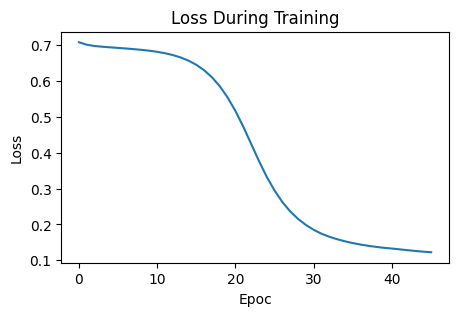

In [330]:
plt.figure(figsize=(5, 3))
plt.plot(history.loss_curve_)
plt.title('Loss During Training')
plt.xlabel('Epoc')
plt.ylabel('Loss')
plt.show()

### 7.3. Confusion Matrix

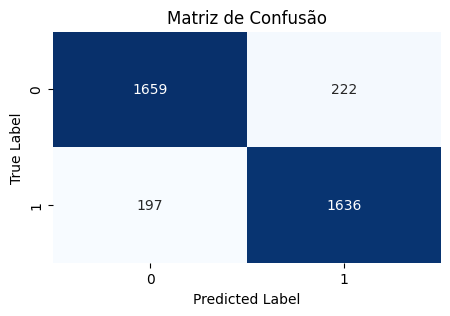

In [331]:
# Fazer previsões no conjunto de teste
predictions = analyze_sentiment.predict(X_test)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(sentiment_test, predictions)

# Plotar a matriz de confusão
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 7.4. Curve ROC

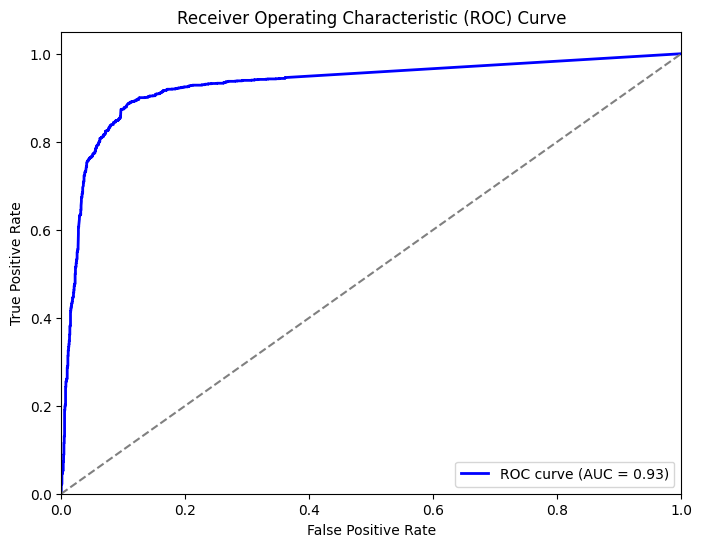

In [332]:
# Calcular as probabilidades previstas para a classe positiva
probas_pred = analyze_sentiment.predict_proba(X_test)[:, 1]

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(sentiment_test, probas_pred)

# Calcular a área sob a curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 8. Test and Deploy IA

In [333]:
# Ajustar configurações para mostrar o texto completo
pd.set_option('display.max_colwidth', None)

texto_teste_vetorizado = cv.transform(df_remaining['review_comment_message'])
texto_teste_normalizado = normalization.transform(texto_teste_vetorizado)
sentimento_predito = analyze_sentiment.predict(texto_teste_normalizado)

df_remaining['sentimento_predito'] = sentimento_predito

df_remaining['sentimento_predito'] = df_remaining['sentimento_predito'].replace({0: 'negativo', 1: 'positivo'})

print(df_remaining[['review_comment_message', 'review_score', 'sentimento_predito']])

df_remaining[['review_comment_message', 'review_score', 'sentimento_predito']].to_csv('dados_processados.csv', index=False)


                                                                                                                                                                              review_comment_message  \
0      nao interessar se operar market place o compra ser fazer em o site de o lannister e pagar para lannister se ter que ajuizar ir ser contra lannister e la facar o regresso contra o fornecedor   
1                                                                                                                                      confiabilidade com informacoe correto e presteza em o entrega   
2                                                                                                                   produto de bom qualidade chegar antes de o prazo vendedor extremamente atencioso   
3                                                                                                                                                                          entregar antes de o prazo   


## division

In [ ]:
# Definir os hiperparâmetros a serem testados
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Criar o modelo MLPClassifier
mlp = MLPClassifier(max_iter=100)

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=2)

# Treinar o modelo usando a pesquisa em grade
grid_search.fit(X, sentiment_train)

# Melhores parâmetros encontrados
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Avaliar o desempenho do modelo
print("Acurácia da melhor configuração no conjunto de validação:")
print(grid_search.best_score_)